# Домашняя работа «Оценка точности модели, переобучение, регуляризация» обновленное

Решить задачу классификации при помощи обучения модели логистической регрессии. Качество модели оценивается путем подсчета метрик TPR, FPR и построения графиков ROC-кривой, Precision-Recall. Данные для обучения модели хранятся в файле athletes.csv, который можно найти в материалах к занятию.
    
Результат:
проведена оценка качества модели классификации;
реализован подсчет «вручную» основных метрик, проведено сравнение полученных результатов с готовыми функциями из библиотеки sklearn.

# Загрузка данных и библиотек

In [76]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno    #библиотека визуализации пропусков

from itables import init_notebook_mode  # интерактивные таблицы расширения `itables`
init_notebook_mode(all_interactive=True)

<IPython.core.display.Javascript object>

In [37]:
data_load = pd.read_csv('athletes.csv')

In [38]:
data_load.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11538 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           11538 non-null  int64  
 1   name         11538 non-null  object 
 2   nationality  11538 non-null  object 
 3   sex          11538 non-null  object 
 4   dob          11537 non-null  object 
 5   height       11208 non-null  float64
 6   weight       10879 non-null  float64
 7   sport        11538 non-null  object 
 8   gold         11538 non-null  int64  
 9   silver       11538 non-null  int64  
 10  bronze       11538 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 991.7+ KB


In [39]:
data_load

id                name nationality     sex       dob  height  \
0      736041664      A Jesus Garcia         ESP    male  10/17/69    1.72   
1      532037425          A Lam Shin         KOR  female   9/23/86    1.68   
2      435962603         Aaron Brown         CAN    male   5/27/92    1.98   
3      521041435          Aaron Cook         MDA    male    1/2/91    1.83   
4       33922579          Aaron Gate         NZL    male  11/26/90    1.81   
...          ...                 ...         ...     ...       ...     ...   
11533  265605954  Zurian Hechavarria         CUB  female   8/10/95    1.64   
11534  214461847      Zuzana Hejnova         CZE  female  12/19/86    1.73   
11535   88361042             di Xiao         CHN    male   5/14/91    1.85   
11536  900065925   le Quoc Toan Tran         VIE    male    4/5/89    1.60   
11537  711404576      le Roux Hamman         RSA    male    1/6/92    1.85   

       weight          sport  gold  silver  bronze  
0        64.0      athletics     0       0       0  
1        56.0        fencing     0       0       0  
2        79.0      athletics     0       0       1  
3        80.0      taekwondo     0       0       0  
4        71.0        cycling     0       0       0  
...       ...            ...   ...     ...     ...  
11533    58.0      athletics     0       0       0  
11534    63.0      athletics     0       0       0  
11535   100.0      wrestling     0       0       0  
11536    56.0  weightlifting     0       0       0  
11537    70.0      athletics     0       0       0  

[11538 rows x 11 columns]

## 1. Преобразуйте данные:

###     a. Проверьте наличие пропущенных значений. Преобразуйте/удалите пропуски по необходимости;

In [40]:
# удаляются столбцы id, name, dob за ненадобностью
data_light = data_load.drop(columns=['id', 'name', 'dob'])
data_light

nationality     sex  height  weight          sport  gold  silver  bronze
0             ESP    male    1.72    64.0      athletics     0       0       0
1             KOR  female    1.68    56.0        fencing     0       0       0
2             CAN    male    1.98    79.0      athletics     0       0       1
3             MDA    male    1.83    80.0      taekwondo     0       0       0
4             NZL    male    1.81    71.0        cycling     0       0       0
...           ...     ...     ...     ...            ...   ...     ...     ...
11533         CUB  female    1.64    58.0      athletics     0       0       0
11534         CZE  female    1.73    63.0      athletics     0       0       0
11535         CHN    male    1.85   100.0      wrestling     0       0       0
11536         VIE    male    1.60    56.0  weightlifting     0       0       0
11537         RSA    male    1.85    70.0      athletics     0       0       0

[11538 rows x 8 columns]

In [41]:
# подсчёт процента пропусков
(data_light.isna().sum() / len(data_light)).round(4) * 100

nationality    0.00
sex            0.00
height         2.86
weight         5.71
sport          0.00
gold           0.00
silver         0.00
bronze         0.00
dtype: float64

In [42]:
# группировка фрейма по виду спорта для определения внутригрупповой медианы
data_all = data_light.copy()
data_group = data_all.groupby('sport')

In [43]:
# определение внутригруппового медиаонного роста
data_height = data_group.height.median()
# определение внутригруппового медианного веса
data_weight = data_group.weight.median()

In [44]:
# замена пропусков в столбцах медианными значениями в рамках вида спорта
data_all.height = data_group.height.transform(lambda x: x.fillna(x.median()))
data_all.weight = data_group.weight.transform(lambda x: x.fillna(x.median()))

In [45]:
# вариант записи одной строкой
# data_all['height'] = data_all.groupby('sport')['height'].transform(lambda x: x.fillna(x.mean()))
# data_all['weight'] = data_all.groupby('sport')['weight'].transform(lambda x: x.fillna(x.mean()))

In [46]:
(data_all.isna().sum() / len(data_all)).round(4) * 100

nationality    0.00
sex            0.00
height         0.00
weight         2.48
sport          0.00
gold           0.00
silver         0.00
bronze         0.00
dtype: float64

In [47]:
data_full = data_all.dropna()

### b. закодируйте категориальные переменные числовыми значениями по необходимости.

In [48]:
data_full

nationality     sex  height  weight          sport  gold  silver  bronze
0             ESP    male    1.72    64.0      athletics     0       0       0
1             KOR  female    1.68    56.0        fencing     0       0       0
2             CAN    male    1.98    79.0      athletics     0       0       1
3             MDA    male    1.83    80.0      taekwondo     0       0       0
4             NZL    male    1.81    71.0        cycling     0       0       0
...           ...     ...     ...     ...            ...   ...     ...     ...
11533         CUB  female    1.64    58.0      athletics     0       0       0
11534         CZE  female    1.73    63.0      athletics     0       0       0
11535         CHN    male    1.85   100.0      wrestling     0       0       0
11536         VIE    male    1.60    56.0  weightlifting     0       0       0
11537         RSA    male    1.85    70.0      athletics     0       0       0

[11252 rows x 8 columns]

In [49]:
# кодирование переменных с помощью OneHotEncoder бибилотеки category_encoders
import category_encoders as ce

In [50]:
ohe_encoder = ce.OneHotEncoder(cols=['nationality', 'sport'], use_cat_names=True)

In [51]:
data = ohe_encoder.fit_transform(data_full)
data

nationality_ESP  nationality_KOR  nationality_CAN  nationality_MDA  \
0                    1                0                0                0   
1                    0                1                0                0   
2                    0                0                1                0   
3                    0                0                0                1   
4                    0                0                0                0   
...                ...              ...              ...              ...   
11533                0                0                0                0   
11534                0                0                0                0   
11535                0                0                0                0   
11536                0                0                0                0   
11537                0                0                0                0   

       nationality_NZL  nationality_AUS  nationality_USA  nationality_ETH  \
0                    0                0                0                0   
1                    0                0                0                0   
2                    0                0                0                0   
3                    0                0                0                0   
4                    1                0                0                0   
...                ...              ...              ...              ...   
11533                0                0                0                0   
11534                0                0                0                0   
11535                0                0                0                0   
11536                0                0                0                0   
11537                0                0                0                0   

       nationality_BRN  nationality_IOA  ...  sport_basketball  sport_golf  \
0                    0                0  ...                 0           0   
1                    0                0  ...                 0           0   
2                    0                0  ...                 0           0   
3                    0                0  ...                 0           0   
4                    0                0  ...                 0           0   
...                ...              ...  ...               ...         ...   
11533                0                0  ...                 0           0   
11534                0                0  ...                 0           0   
11535                0                0  ...                 0           0   
11536                0                0  ...                 0           0   
11537                0                0  ...                 0           0   

       sport_archery  sport_weightlifting  sport_sailing  sport_tennis  \
0                  0                    0              0             0   
1                  0                    0              0             0   
2                  0                    0              0             0   
3                  0                    0              0             0   
4                  0                    0              0             0   
...              ...                  ...            ...           ...   
11533              0                    0              0             0   
11534              0                    0              0             0   
11535              0                    0              0             0   
11536              0                    1              0             0   
11537              0                    0              0             0   

       sport_gymnastics  gold  silver  bronze  
0                     0     0       0       0  
1                     0     0       0       0  
2                     0     0       0       1  
3                     0     0       0       0  
4                     0     0       0       0  
...                 ...   ...     ...     .

## 2. Разделите выборку на обучающее (80% данных) и тестовое (20% данных) подмножества.

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [53]:
# формирование набора признаков
del data['sex']
X = data
X.head()

nationality_ESP  nationality_KOR  nationality_CAN  nationality_MDA  \
0                1                0                0                0   
1                0                1                0                0   
2                0                0                1                0   
3                0                0                0                1   
4                0                0                0                0   

   nationality_NZL  nationality_AUS  nationality_USA  nationality_ETH  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                1                0                0                0   

   nationality_BRN  nationality_IOA  ...  sport_basketball  sport_golf  \
0                0                0  ...                 0           0   
1                0                0  ...                 0           0   
2                0                0  ...                 0           0   
3                0                0  ...                 0           0   
4                0                0  ...                 0           0   

   sport_archery  sport_weightlifting  sport_sailing  sport_tennis  \
0              0                    0              0             0   
1              0                    0              0             0   
2              0                    0              0             0   
3              0                    0              0             0   
4              0                    0              0             0   

   sport_gymnastics  gold  silver  bronze  
0                 0     0       0       0  
1                 0     0       0       0  
2                 0     0       0       1  
3                 0     0       0       0  
4                 0     0       0       0  

[5 rows x 239 columns]

In [54]:
# формирование целевых переменных
le = LabelEncoder()
le.fit(data_full['sex'])

LabelEncoder()

In [55]:
Y = pd.Series(data=le.transform(data_full['sex']))
Y.head()

0
Loading... (need help?)


In [56]:
model = LogisticRegression()

In [57]:
# разбитие модели на обучающую и тестовую выборки в соотношении 80 / 20
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

In [58]:
# обучение модели
model.fit(X_train, Y_train)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [59]:
predictions = model.predict_proba(X_test)

## 3. Постройте ROC-кривую с помощью функции sklearn.metrics. roc_curve.

In [60]:
from sklearn.metrics import roc_curve

In [61]:
# получение FP И TP для различных значений порога
fpr, tpr, thres = roc_curve(Y_test, predictions[:, 1])

In [62]:
# for line in zip(fpr, tpr, thres):
#     print(line)

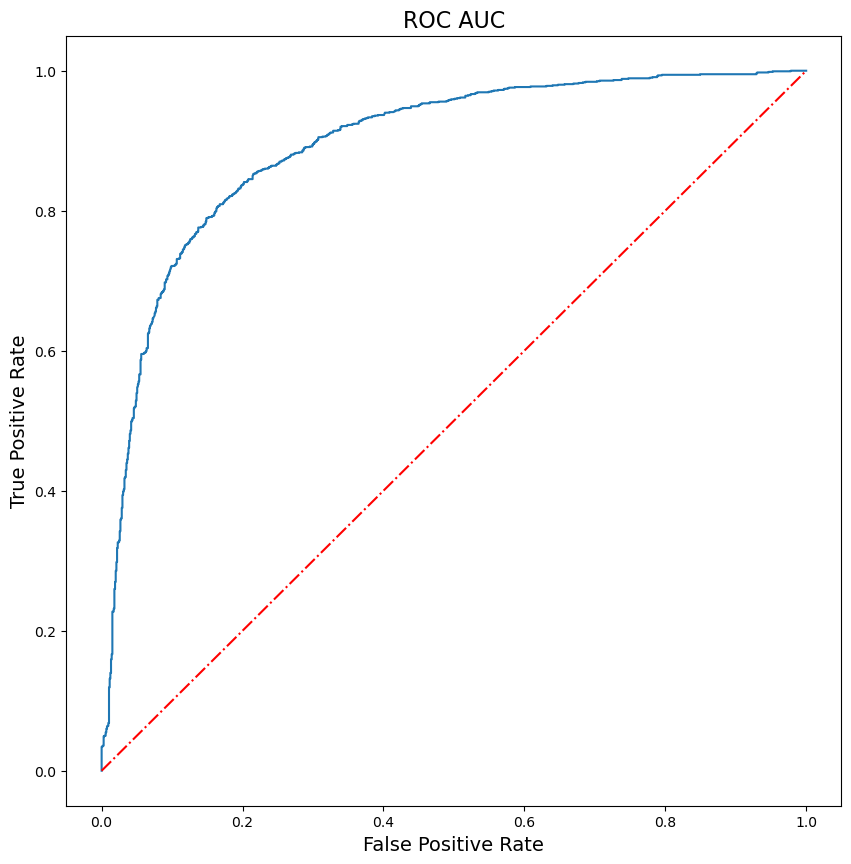

In [63]:
plt.figure(figsize=(10, 10))
plt.title('ROC AUC', fontdict={'fontsize': 16})
plt.xlabel('False Positive Rate', fontdict={'fontsize': 14})
plt.ylabel('True Positive Rate', fontdict={'fontsize': 14})
plt.plot(fpr, tpr)
# plt.axline((1, 1), slope=1, color="r", linestyle='dashdot')
plt.plot([0, 1],[0, 1], color='r', linestyle='dashdot')
plt.show()


## 4. Вычислите значение ROC-AUC метрики с помощью функции sklearn.metrics.roc_auc_score.

In [64]:
from sklearn.metrics import roc_auc_score

In [65]:
roc_auc_score( Y_test, predictions[:, 1])

0.892691011458705

## 5. Реализуйте подсчет метрик TPR, FPR «вручную», без использования готовых функций из библиотеки sklearn.

In [66]:
from numpy import arange

# порог задан с шагом 0.1
thresholds = arange(0, 1, 0.1)
FPRS = []  #доля неправильно предсказанных среди отрицательных случаев
TPRS = []  #доля правилно предсказанных среди положительлных случаев
precisions = []  #доля правильно предсказанных среди всех случаев
recalls = []  #доля правильно предсказанных среди положительных случаев

for threshold in thresholds:
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    predictions = model.predict_proba(X_test)
    for predicted_prob, actual in zip(predictions[:, 1], Y_test):
        if predicted_prob >= threshold:
            predicted = 1
        else:
            predicted = 0

        if predicted == 1:
            if actual == 1:
                TP += 1
            else:
                FP += 1

        else:
            if actual == 1:
                FN += 1
            else:
                TN += 1
    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)
    precision = TP/(TP + FP)
    recall = TPR
    
    FPRS.append(FPR)
    TPRS.append(TPR)
    precisions.append(precision)
    recalls.append(recall)

## 6. Постройте ROC-кривую с помощью вычисленных в п. 5 метрик: объедините графики из п. 3 и п. 6 в один. Сравните, сделайте вывод.

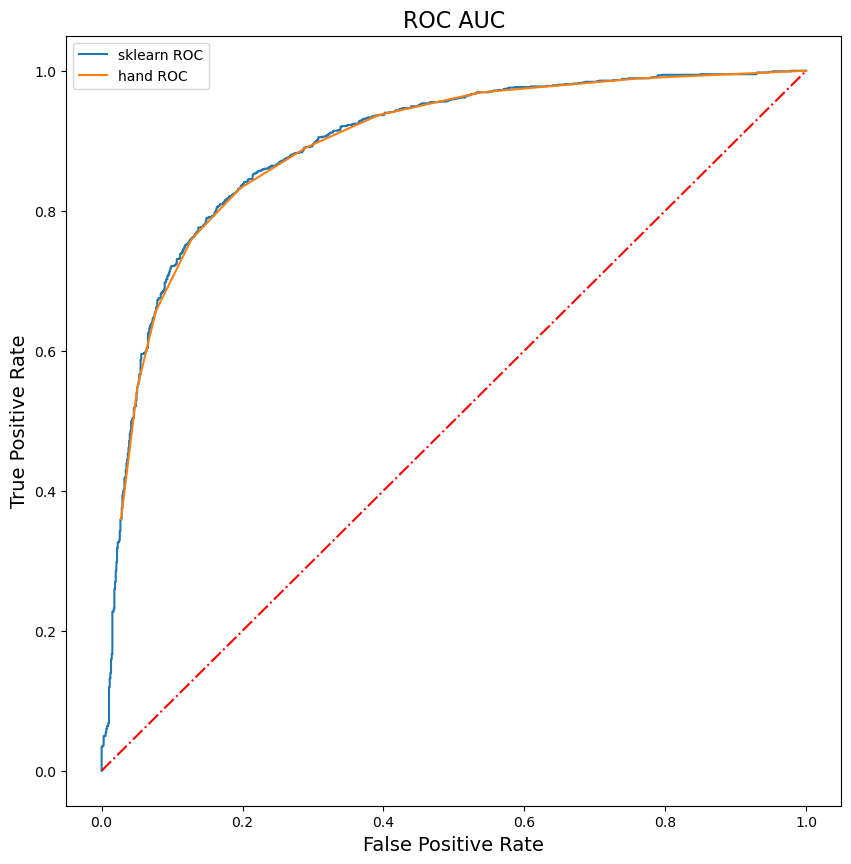

In [67]:
plt.figure(figsize=(10, 10))
plt.title('ROC AUC', fontdict={'fontsize': 16})
plt.xlabel('False Positive Rate', fontdict={'fontsize': 14})
plt.ylabel('True Positive Rate', fontdict={'fontsize': 14})
plt.plot(fpr, tpr, label="sklearn ROC")
plt.plot(FPRS, TPRS, label="hand ROC")
# plt.axline((1, 1), slope=1, color="r", linestyle='dashdot')
plt.plot([0, 1], [0, 1], color='r', linestyle='dashdot')
plt.legend()
plt.show()

## 7. Постройте график Precision-Recall, используя метрики, посчитанные в п. 5.

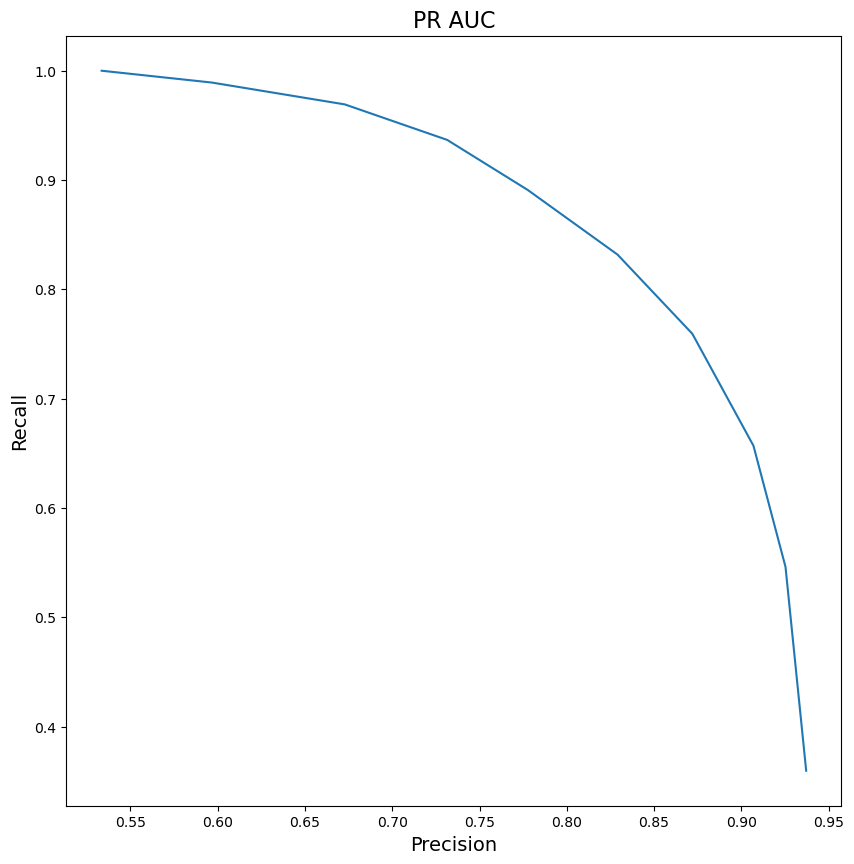

In [74]:
plt.figure(figsize=(10, 10))
plt.title('PR AUC', fontdict={'fontsize': 16})
plt.xlabel('Precision', fontdict={'fontsize': 14})
plt.ylabel('Recall', fontdict={'fontsize': 14})
plt.plot(precisions, recalls)
plt.show()

## 8. *Вычислите значение ROC-AUC метрики, используя метрики, посчитанные в п. 5.

In [73]:
#сортируем для подсчета от начала кривой
FPRS.sort()
TPRS.sort()
#приблизительно моделируем площадь фигуры как сумму фигур по шагам
custom_roc_auc = 0
prev_fpr = 0
prev_tpr = 0
for index in range(len(FPRS)):
    if(index != 0):
        custom_roc_auc += ((TPRS[index] - prev_tpr) * (FPRS[index] - prev_fpr) / 2) + (TPRS[index] * (FPRS[index] - prev_fpr))
        prev_tpr = TPRS[index]
        prev_fpr = FPRS[index]
print(f'ROC-AUC метрика равна {custom_roc_auc:.2f}')

ROC-AUC метрика равна 0.95


## 9. Сформулируйте выводы по проделанной работе:

a. как по полученным графикам сделать вывод о качестве модели? Как вы оцениваете обученную модель исходя из подсчитанных метрик?

По ROC-кривой качество модели тем выше, чем кривая выше от диагонали и соответственно больше площадь под кривой.

По большой площади PR-кривой можно сказать, что в обучающих данных минимум шума и модель хорошо выявляет закономерности, по которым отличает классы.  

Обученная модель получилась высокого качества.


b. *может ли ROC-кривая проходить ниже диагонали?

ROC-кривая может проходить ниже диагонали, это будет свидетельствовать о том, что модель является безполезной, т.к. её качество хуже даже случайного предскзания 50/50, которым является диагональ.

In [70]:
from IPython.display import Image

display(Image(url="https://loginom.ru/sites/default/files/blogpost-files/roc-curve.svg", 
              width = 900))